# Keystroke Dynamics Analysis and Prediction w/ XGB

Keystroke dynamics basically deals with the analysis of keystroke patterns of a user. In one of its use cases, this can essentially enable companies to provide non-intrusive real-time authentication of users.

By capturing the duration between 2 key presses, the duration of pressing down a key, and the duration between the current key release and the next key press can provide great insights about the user. The next time this user logs in, by comparing his current typing pattern with his previous typing patterns, companies can authenticate whether the logged in user is legitimate or fraudulent.


<br/>
<img src='https://media0.giphy.com/media/13GIgrGdslD9oQ/giphy.gif'/>
<br/>


The dataset [Keystroke dynamics challenge 1 | Kaggle](https://www.kaggle.com/c/keystroke-dynamics-challenge-1/data) has been used in this notebook. This dataset captures typing attempts of 110 users. Each user has attempted 8 times to type the string 'united states' and the corresponding timestamps of key press and release relative to the first key press have been captured.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
trainDF = pd.read_csv('/kaggle/input/keystroke-dynamics-challenge-1/train.csv')
testDF = pd.read_csv('/kaggle/input/keystroke-dynamics-challenge-1/test.csv')

# First Glance

Let's have a first glance of how the dataset actually looks like

In [3]:
trainDF.head()

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,1,0,120,216,312,424,496,592,664,808,...,1712,1760,1992,2064,2376,2448,2584,2632,2752,2824
1,1,0,95,168,265,360,455,527,599,736,...,1423,1471,1664,1711,1880,1952,2039,2111,2231,2279
2,1,0,71,143,231,783,903,1087,1159,1351,...,2039,2111,2271,2343,2487,2559,2679,2751,2871,2926
3,1,0,95,144,263,353,431,760,832,1159,...,3151,3223,3415,3463,3631,3703,3815,3887,3983,4055
4,1,0,70,166,238,310,406,526,598,710,...,1310,1382,1543,1605,1734,1806,1926,1998,2086,2182


In [4]:
testDF.head()

,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,0,96,239,337,407,537,740,839,928,1047,...,1831,1951,2032,2138,2430,2496,2567,2691,2824,2919
1,0,87,248,319,515,590,734,803,912,983,...,1839,1911,2103,2174,2383,2487,2575,2647,2815,2886
2,0,90,234,312,404,512,667,767,843,940,...,1572,1675,1771,1890,1948,2043,2147,2255,2540,2683
3,0,193,240,356,407,526,607,732,712,769,...,1600,1728,1744,1832,1904,2063,2148,2258,2336,2501
4,0,74,324,394,555,629,926,1026,1194,1328,...,2626,2754,2922,3068,3154,3259,3386,3453,3618,3698


In [5]:
print('No. of rows in training dataset:',len(trainDF))
print('No. of users for which training data is present:',trainDF.user.nunique())

No. of rows in training dataset: 880
No. of users for which training data is present: 110


In [6]:
print('No. of rows in test dataset:',len(testDF))

No. of rows in test dataset: 220


## Generate features

Now, by itself, these timestamps would mean nothing. We can gain insights on user typing patterns by creating features such as press-press duration (PPD), hold duration (HD), release-press duration (RPD).

The image shows the duration calculations for pressing 2 keys - A and B. Here, the smaller keys represent the key press event and the larger ones represent the key release event.

<br/>
<img src='https://www.researchgate.net/profile/Ivan_Homoliak/publication/324536760/figure/fig4/AS:615900302544896@1523853483320/Low-level-keystroke-dynamics-features_W640.jpg'/>
<br/>

Image Credits: ['The Wolf of SUTD (TWOS): A dataset of malicious insider threat behavior based on a gamified competition'](https://www.researchgate.net/publication/324536760_The_Wolf_of_SUTD_TWOS_A_dataset_of_malicious_insider_threat_behavior_based_on_a_gamified_competition)

In [7]:
trainDF1 = trainDF
for i in range(1,13):
    trainDF1['PPD-'+str(i)] = trainDF1['press-'+str(i)] - trainDF1['press-'+str(i-1)]
    trainDF1['RPD-'+str(i)] = trainDF1['release-'+str(i)] - trainDF1['press-'+str(i-1)]

for i in range(13):
    trainDF1['HD-'+str(i)] = trainDF1['release-'+str(i)] - trainDF1['press-'+str(i)]
    
testDF1 = testDF
for i in range(1,13):
    testDF1['PPD-'+str(i)] = testDF1['press-'+str(i)] - testDF1['press-'+str(i-1)]
    testDF1['RPD-'+str(i)] = testDF1['release-'+str(i)] - testDF1['press-'+str(i-1)]

for i in range(13):
    testDF1['HD-'+str(i)] = testDF1['release-'+str(i)] - testDF1['press-'+str(i)]

In [8]:
trainDF1.head()

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,HD-3,HD-4,HD-5,HD-6,HD-7,HD-8,HD-9,HD-10,HD-11,HD-12
0,1,0,120,216,312,424,496,592,664,808,...,72,48,72,96,48,48,72,72,48,72
1,1,0,95,168,265,360,455,527,599,736,...,72,71,71,71,56,48,47,72,72,48
2,1,0,71,143,231,783,903,1087,1159,1351,...,72,103,72,96,79,72,72,72,72,55
3,1,0,95,144,263,353,431,760,832,1159,...,72,48,50,91,47,72,48,72,72,72
4,1,0,70,166,238,310,406,526,598,710,...,72,48,72,96,72,72,62,72,72,96


# EDA

Let's now perform an exploratory data analysis on these features to understand the significant features.

In [9]:
# Check stats of first 5 users i.e. 5 x 8 typing patterns
noOfUsers = 5
if noOfUsers == -1:
    trainDF2 = trainDF1
else:
    trainDF2 = trainDF1[:noOfUsers*8]

In [10]:
temp1 = pd.DataFrame({'Min':trainDF2.min(),'Max':trainDF2.max()})
temp1.head()

,Min,Max
user,1,5
press-0,0,0
release-0,0,120
press-1,0,253
release-1,78,360


## Scatterplot of PPD vs RPD

Let's check how a scatterplot of RPD v/s PPD will look like. Note, PPD = HD + RPD. Thus, these should be almost linearly related which is evident from the following plot

Text(0.5, 1.0, 'Scatterplot of PPD vs RPD')

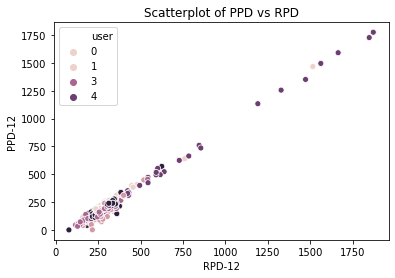

In [11]:
for i in range(1,13):
    ax = sns.scatterplot(x='RPD-'+str(i),y='PPD-'+str(i),hue='user',data=trainDF2)

# Small trick to avoid repeating legends: https://stackoverflow.com/a/36268401/5370202    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:noOfUsers], labels[:trainDF2.user.nunique()])
ax.set_title('Scatterplot of PPD vs RPD')

## Swarm Plots of RPD, PPD, HD

Next, let's analyse the swarmplots of RPD, PPD, HD for each user. Since, there are 8 typing patterns per user and each typing pattern consists of 13 key strokes, we have 8 x 13 = 104 data points per user.

Here, we are using an interesting feature of seaborn charts. Now, since we have 12 RPD values per typing pattern (consecutive pairs from 13 key presses), we need to visualise all these durations together. So, we invoke swarmplot for each of these 12 columns back-to-back and seaborn overlays the data from all of these visualisations together.

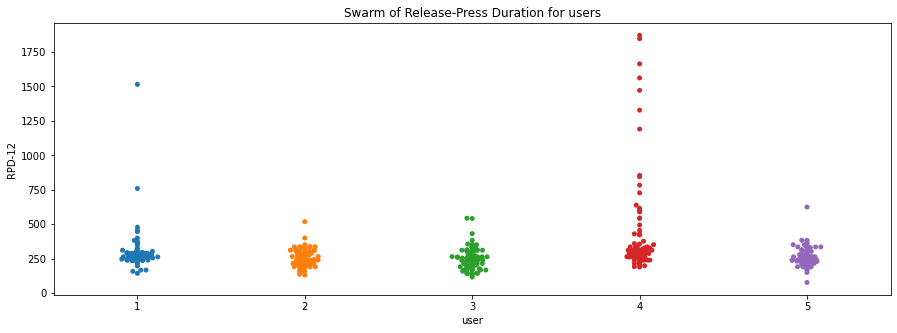

In [12]:
plt.figure(figsize=(15,5))
for i in range(1,13):
    sns.swarmplot(y='RPD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Release-Press Duration for users')

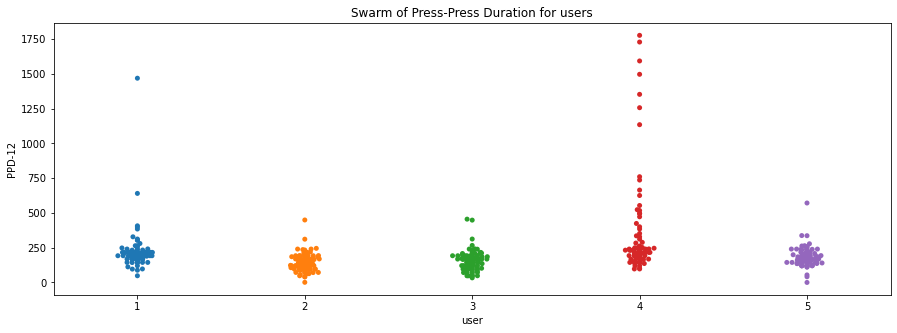

In [13]:
plt.figure(figsize=(15,5))
for i in range(1,13):
    sns.swarmplot(y='PPD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Press-Press Duration for users')

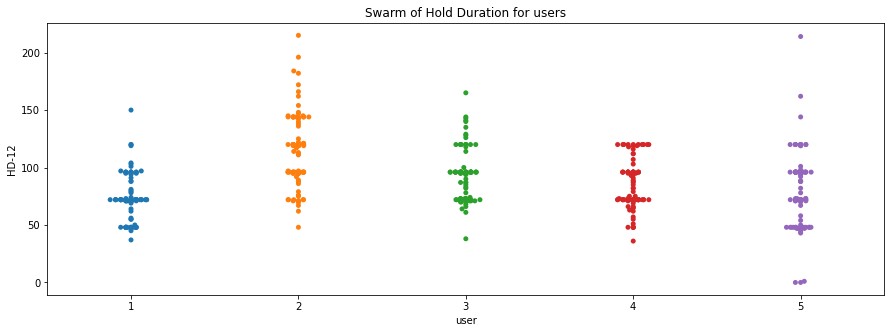

In [14]:
plt.figure(figsize=(15,5))
for i in range(13):
    sns.swarmplot(y='HD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Hold Duration for users')

As, you can see from the swarm plots, the press-press duration, release-press durations is roughly the same across all users. Thus, directly using an average duration will not be helpful.

However, hold duration is roughly different for each user which is correct since each user has a different typing speed according to his familiarity with typing.

Let's plan to use histograms to check if any variations could be identified

## Further Analysis of HD, PPD, RPD by understanding key sequences

Since we know that each typing pattern consists of 13 keystrokes, let's try to visualise scatter plots and line plots of how these durations would look in terms of the timestamps of key press events. Note, since each typing pattern is independent of the other, we construct 8 line plots (consisting of 13 data points) for each of the 5 users resulting in 8 x 5 = 40 line plots.

### Hold Duration key sequences

Here, an interesting pandas function `wide_to_long` is used. In order to analyse these sequences, we need all these durations to present in 1 column as against spread across multiple columns of a row. So, `wide_to_long` stacks all these values present in multiple columns into a single column. By sorting in the sequence: `user`,`id`,`key_no`, we ensure that all durations of a single typing pattern are together.

In [15]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_HD_analysis = ['PPD-'+str(i) for i in range(1,13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)]

trainDF_HD_analysis = trainDF2.drop(columns=drop_cols_HD_analysis)
trainDF_HD_analysis['id'] = trainDF_HD_analysis.index
trainDF_HD_analysis = pd.wide_to_long(trainDF_HD_analysis,['press-','HD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
trainDF_HD_analysis

user  press-  HD-
id key_no                   
0  0          1       0  120
   1          1     216   96
   2          1     424   72
   3          1     592   72
   4          1     808   48
...         ...     ...  ...
39 8          5    1267   43
   9          5    1420   82
   10         5    1574   72
   11         5    1710   96
   12         5    1950   73

[520 rows x 3 columns]

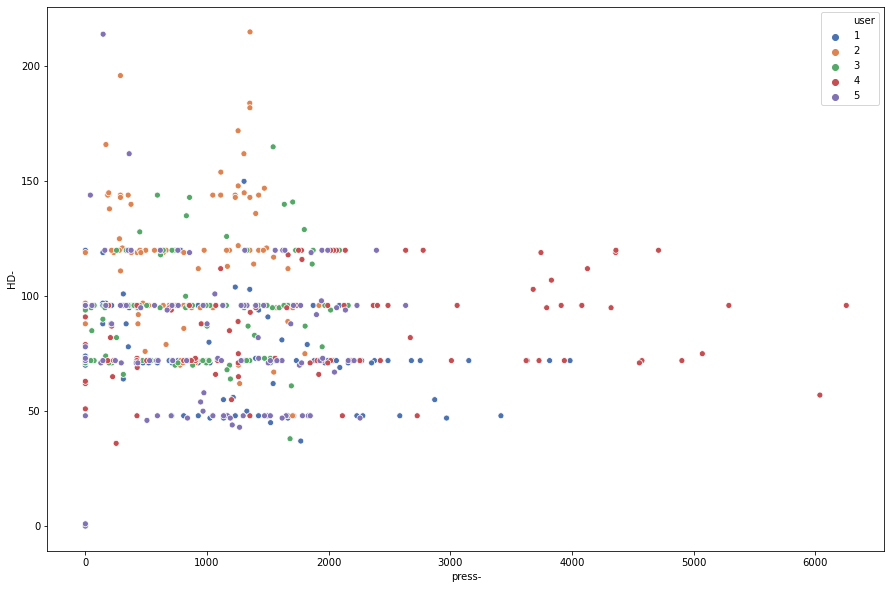

In [16]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='HD-',hue='user',data=trainDF_HD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

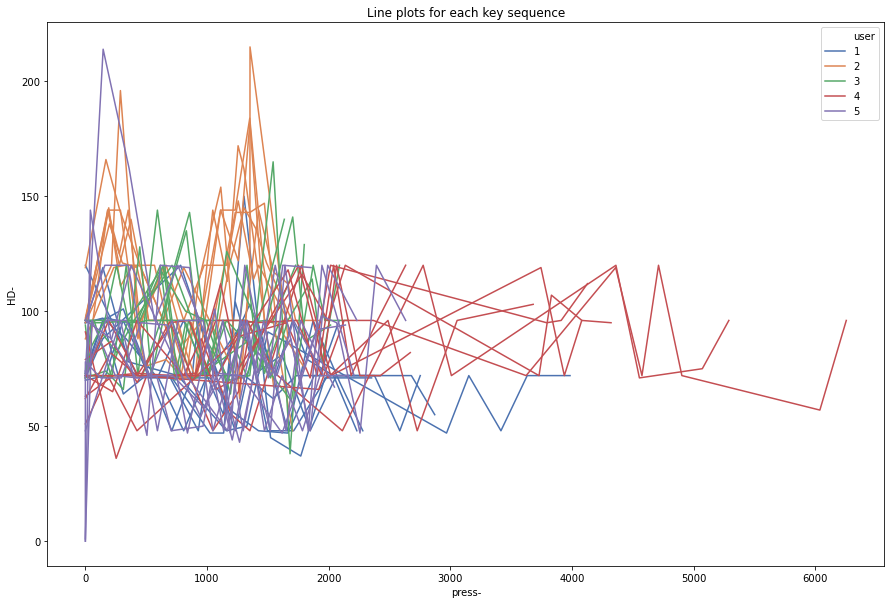

In [17]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='HD-',hue='user',units='id',estimator=None,data=trainDF_HD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

### Press-Press Duration key sequences

In [18]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_PPD_analysis = ['HD-'+str(i) for i in range(13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_PPD_analysis = trainDF2.drop(columns=drop_cols_PPD_analysis)
trainDF_PPD_analysis['id'] = trainDF_PPD_analysis.index
trainDF_PPD_analysis = pd.wide_to_long(trainDF_PPD_analysis,['press-','PPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
# trainDF_PPD_analysis

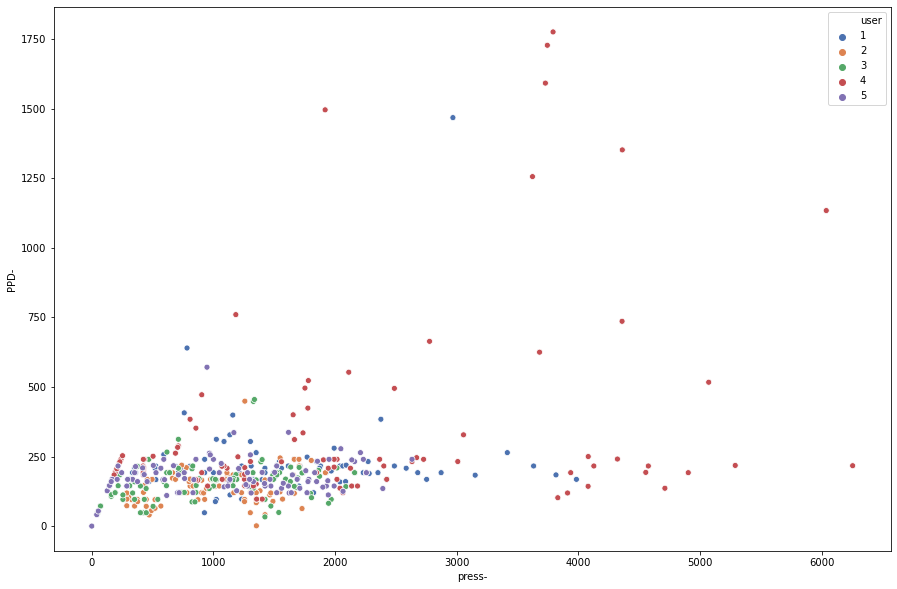

In [19]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='PPD-',hue='user',data=trainDF_PPD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

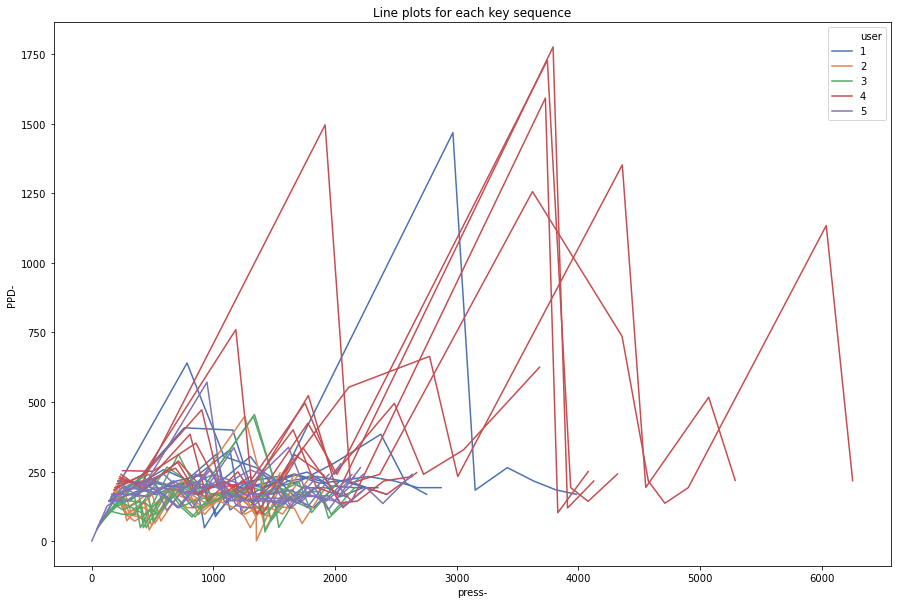

In [20]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='PPD-',hue='user',units='id',estimator=None,data=trainDF_PPD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

**This plot reveals a very interesting detail.**

Notice the jagged lines for user 4 (red lines). The PPD suddenly increases and then becomes very low for the next key. This means that this user waits for a relatively longer time before typing in 2 keys back to back. So, we could say this user typically types in groups of 2 keys

### Release-Press Duration key sequences

In [21]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_RPD_analysis = ['HD-'+str(i) for i in range(13)] + ['PPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_RPD_analysis = trainDF2.drop(columns=drop_cols_RPD_analysis)
trainDF_RPD_analysis['id'] = trainDF_RPD_analysis.index
trainDF_RPD_analysis = pd.wide_to_long(trainDF_RPD_analysis,['press-','RPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
# trainDF_RPD_analysis

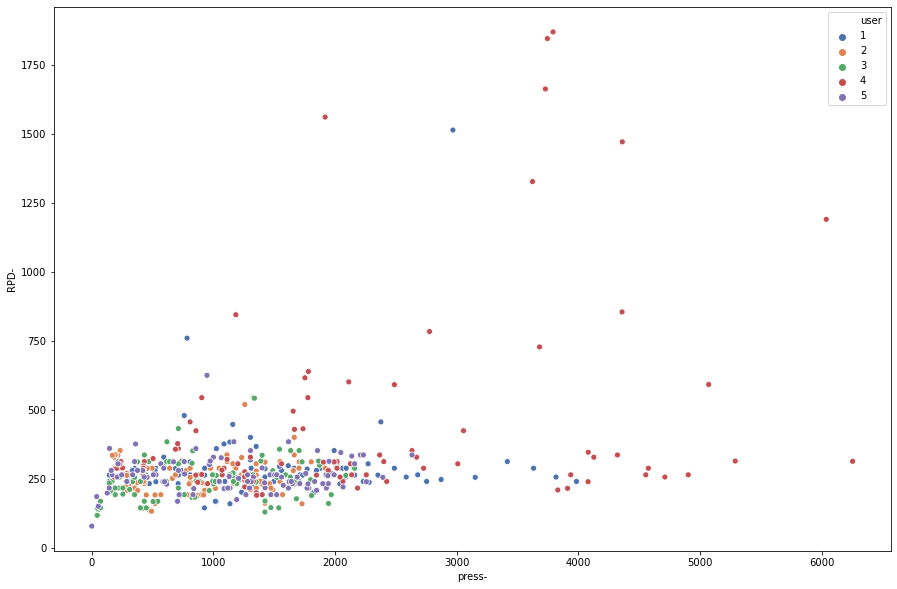

In [22]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='RPD-',hue='user',data=trainDF_RPD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

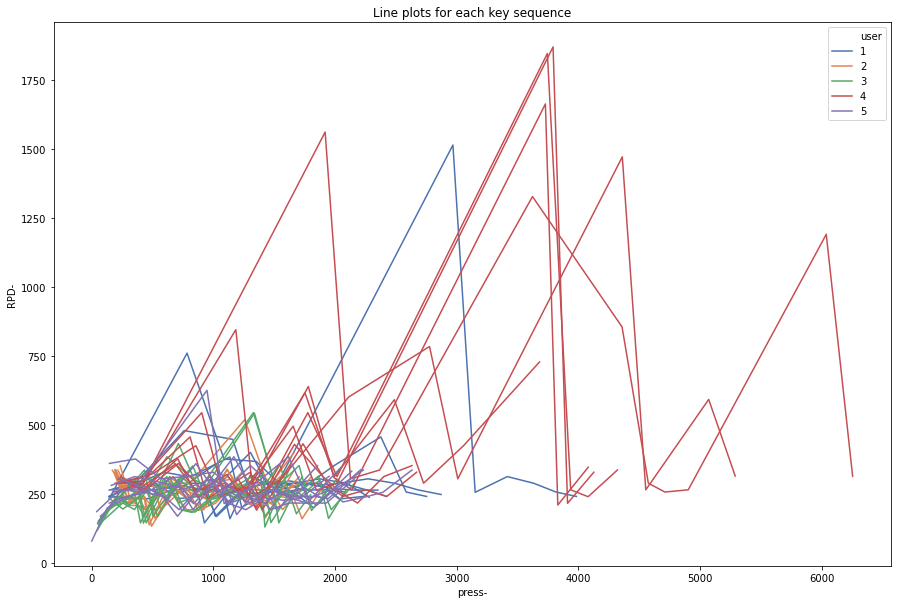

In [23]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='RPD-',hue='user',units='id',estimator=None,data=trainDF_RPD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

This plot reveals the same detail as PPD. 

Notice the jagged lines for user 4. The RPD also suddenly increases and then becomes very low for the next key. This means that this user waits for a relatively longer time before typing in 2 keys back to back. So, we could say this user typically types in groups of 2 keys

# Data Preparation

Instead of directly using these durations as inputs, we could group these durations into histograms which would represent groups of different typing speeds. For e.g. a slow typer would have his keystroke durations falling in the histogram bucket of larger durations. At the same time, a fast typer (or perhaps a touch typer) would have his keystroke durations falling in the histogram bucket of smaller durations.

Thus, we will convert the entire training and test data by using this histogram technique. I believe, this should be enough to gain such insights inherently.

Note that, in the above section, we were analysing typing patterns of only 5 users.

In the following code segment, we are repeating the same steps we performed above for entire train and test data.

In [24]:
## Training Data
drop_cols_HD_analysis = ['PPD-'+str(i) for i in range(1,13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)]

trainDF_HD_analysis = trainDF1.drop(columns=drop_cols_HD_analysis)
trainDF_HD_analysis['id'] = trainDF_HD_analysis.index
trainDF_HD_analysis = pd.wide_to_long(trainDF_HD_analysis,['press-','HD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])

drop_cols_PPD_analysis = ['HD-'+str(i) for i in range(13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_PPD_analysis = trainDF1.drop(columns=drop_cols_PPD_analysis)
trainDF_PPD_analysis['id'] = trainDF_PPD_analysis.index
trainDF_PPD_analysis = pd.wide_to_long(trainDF_PPD_analysis,['press-','PPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])

drop_cols_RPD_analysis = ['HD-'+str(i) for i in range(13)] + ['PPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_RPD_analysis = trainDF1.drop(columns=drop_cols_RPD_analysis)
trainDF_RPD_analysis['id'] = trainDF_RPD_analysis.index
trainDF_RPD_analysis = pd.wide_to_long(trainDF_RPD_analysis,['press-','RPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])


## Test Data
testDF_HD_analysis = testDF1.drop(columns=drop_cols_HD_analysis)
testDF_HD_analysis['id'] = testDF_HD_analysis.index
testDF_HD_analysis = pd.wide_to_long(testDF_HD_analysis,['press-','HD-'],i='id',j='key_no').sort_values(by=['id','key_no'])

testDF_PPD_analysis = testDF1.drop(columns=drop_cols_PPD_analysis)
testDF_PPD_analysis['id'] = testDF_PPD_analysis.index
testDF_PPD_analysis = pd.wide_to_long(testDF_PPD_analysis,['press-','PPD-'],i='id',j='key_no').sort_values(by=['id','key_no'])

testDF_RPD_analysis = testDF1.drop(columns=drop_cols_RPD_analysis)
testDF_RPD_analysis['id'] = testDF_RPD_analysis.index
testDF_RPD_analysis = pd.wide_to_long(testDF_RPD_analysis,['press-','RPD-'],i='id',j='key_no').sort_values(by=['id','key_no'])

In [25]:
## Join these individual tables together
testDFCombined = testDF_HD_analysis.join(testDF_RPD_analysis.drop(columns=['press-']),rsuffix='RPD_').join(testDF_PPD_analysis.drop(columns=['press-']),rsuffix='PPD_')

trainDFCombined = trainDF_HD_analysis.join(trainDF_RPD_analysis.drop(columns=['user','press-']),rsuffix='RPD_').join(trainDF_PPD_analysis.drop(columns=['user','press-']),rsuffix='PPD_')
trainDFCombined

user  press-  HD-   RPD-   PPD-
id  key_no                                 
0   0          1       0  120    NaN    NaN
    1          1     216   96  312.0  216.0
    2          1     424   72  280.0  208.0
    3          1     592   72  240.0  168.0
    4          1     808   48  264.0  216.0
...          ...     ...  ...    ...    ...
879 8        110    1561   63  279.0  216.0
    9        110    1679  119  237.0  118.0
    10       110    1838  128  287.0  159.0
    11       110    1991  105  258.0  153.0
    12       110    2199  159  367.0  208.0

[11440 rows x 5 columns]

The following figures are histograms of HD, PPD, RPD. This makes it clear to have bucketing for better classification.

Text(0.5, 1.0, 'Hist of Release-Press Duration')

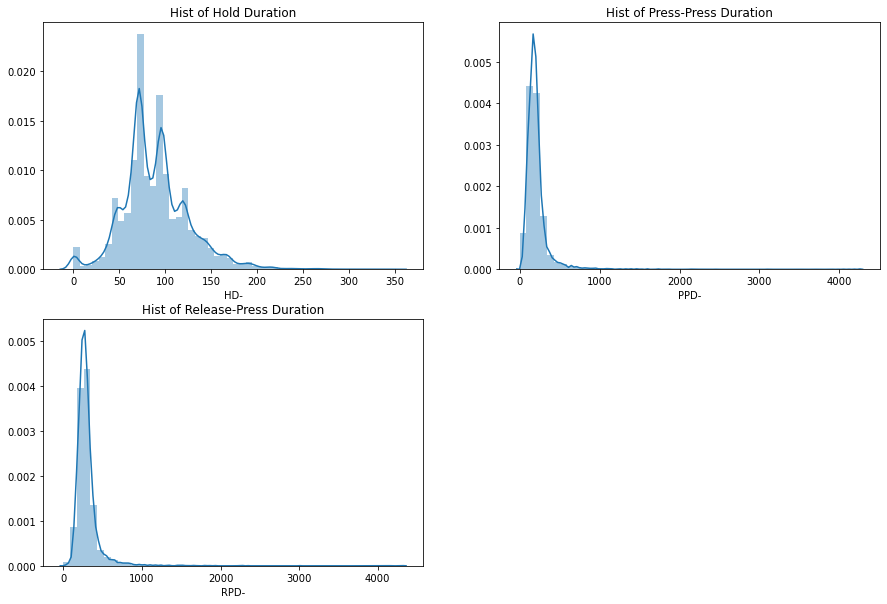

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(trainDFCombined['HD-']).set_title('Hist of Hold Duration')
plt.subplot(2,2,2)
sns.distplot(trainDFCombined['PPD-']).set_title('Hist of Press-Press Duration')
plt.subplot(2,2,3)
sns.distplot(trainDFCombined['RPD-']).set_title('Hist of Release-Press Duration')

Now, instead of determing buckets by ourselves, we can use another interesting pandas function `qcut`. In this function we specify the column name over which we want to perform the binning/bucketing. This function checks the distribution of values in the specified column and divides the distribution into equal frequence `q` number of bins. This ensures that each bin has equal frequency and we can get more meaningful bins. 

We are setting `retbins` to True so that we can later use these bins over our test dataset. For test datasets, since we already have these bins with us, we need not perform `qcut`. Instead we'll use `cut` which directly assigns the values into the appropriate bin.

We are encoding the values to labels 0 - 9 in `HDEnc`, `PPDEnc`, `RPDEnc` corresponding to the bins. Since, there are 12 RPD, 12 PPD, 13 HD values corresponding to the 13 key strokes in a typing pattern, we fill the missing RPD, PPD values by -1

In [27]:
noOfBins = 10

## Training Data
HDMax = trainDFCombined['HD-'].max()
RPDMax = trainDFCombined['RPD-'].max()
PPDMax = trainDFCombined['PPD-'].max()
print('Max values in train are: HDMax:',HDMax,'RPDMax:',RPDMax,'PPDMax:',PPDMax)
labels = [i for i in range(noOfBins)]

trainDFCombined['HDEnc'],HDBins = pd.qcut(trainDFCombined['HD-'],retbins=True,labels=labels,q=noOfBins)
trainDFCombined['PPDEnc'],RPDBins = pd.qcut(trainDFCombined['PPD-'],retbins=True,labels=labels,q=noOfBins)
trainDFCombined['RPDEnc'],PPDBins = pd.qcut(trainDFCombined['RPD-'],retbins=True,labels=labels,q=noOfBins)

trainDFCombined['HDEnc'] = trainDFCombined['HDEnc'].astype(str).replace('nan',-1).astype(int)
trainDFCombined['PPDEnc'] = trainDFCombined['PPDEnc'].astype(str).replace('nan',-1).astype(float)
trainDFCombined['RPDEnc'] = trainDFCombined['RPDEnc'].astype(str).replace('nan',-1).astype(float)


## Test Data
HDMax = testDFCombined['HD-'].max()
RPDMax = testDFCombined['RPD-'].max()
PPDMax = testDFCombined['PPD-'].max()
print('Max values in test data are: HDMax:',HDMax,'RPDMax:',RPDMax,'PPDMax:',PPDMax)
labels = [i for i in range(noOfBins)]

testDFCombined['HDEnc'] = pd.cut(testDFCombined['HD-'],labels=labels,bins=HDBins)
testDFCombined['PPDEnc'] = pd.cut(testDFCombined['PPD-'],labels=labels,bins=RPDBins)
testDFCombined['RPDEnc'] = pd.cut(testDFCombined['RPD-'],labels=labels,bins=PPDBins)

testDFCombined['HDEnc'] = testDFCombined['HDEnc'].astype(str).replace('nan',-1).astype(float)
testDFCombined['PPDEnc'] = testDFCombined['PPDEnc'].astype(str).replace('nan',-1).astype(float)
testDFCombined['RPDEnc'] = testDFCombined['RPDEnc'].astype(str).replace('nan',-1).astype(float)

Max values in train are: HDMax: 348 RPDMax: 4322.0 PPDMax: 4255.0
Max values in test data are: HDMax: 363 RPDMax: 2627.0 PPDMax: 2553.0


In [28]:
trainDFCombined

user  press-  HD-   RPD-   PPD-  HDEnc  PPDEnc  RPDEnc
id  key_no                                                        
0   0          1       0  120    NaN    NaN      8    -1.0    -1.0
    1          1     216   96  312.0  216.0      5     6.0     6.0
    2          1     424   72  280.0  208.0      3     6.0     5.0
    3          1     592   72  240.0  168.0      3     4.0     3.0
    4          1     808   48  264.0  216.0      0     6.0     4.0
...          ...     ...  ...    ...    ...    ...     ...     ...
879 8        110    1561   63  279.0  216.0      1     6.0     5.0
    9        110    1679  119  237.0  118.0      8     1.0     3.0
    10       110    1838  128  287.0  159.0      8     3.0     5.0
    11       110    1991  105  258.0  153.0      7     3.0     4.0
    12       110    2199  159  367.0  208.0      9     6.0     8.0

[11440 rows x 8 columns]

In [29]:
testDFCombined

press-  HD-   RPD-   PPD-  HDEnc  PPDEnc  RPDEnc
id  key_no                                                  
0   0            0   96    NaN    NaN    5.0    -1.0    -1.0
    1          239   98  337.0  239.0    6.0     7.0     7.0
    2          407  130  298.0  168.0    8.0     4.0     6.0
    3          740   99  432.0  333.0    6.0     9.0     9.0
    4          928  119  307.0  188.0    8.0     5.0     6.0
...            ...  ...    ...    ...    ...     ...     ...
219 8         1574   96  256.0  160.0    5.0     3.0     4.0
    9         1705   42  173.0  131.0    0.0     2.0     0.0
    10        1830   67  192.0  125.0    2.0     2.0     1.0
    11        1933   73  176.0  103.0    3.0     1.0     0.0
    12        2150   48  265.0  217.0    0.0     6.0     4.0

[2860 rows x 7 columns]

In [30]:
## Lower limit values of bins created
HDBins, RPDBins, PPDBins, 'No. of buckets: '+str(len(HDBins)-1)

(array([  0. ,  48. ,  64. ,  71. ,  74. ,  86. ,  96. , 100.3, 118. ,
        136. , 348. ]),
 array([   0.,   96.,  122.,  144.,  166.,  183.,  199.,  218.,  249.,
         311., 4255.]),
 array([   0.,  182.,  211.,  234.,  255.,  270.,  289.,  313.,  345.,
         410., 4322.]),
 'No. of buckets: 10')

Now, let's see the swarmplots of the encodings formed by these buckets

Text(0.5, 1.0, 'Swarm plot of binned release-press duration')

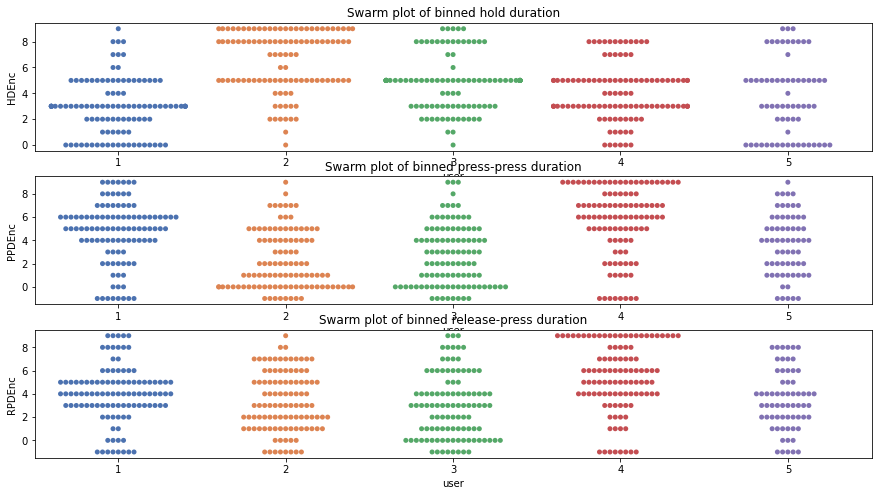

In [31]:
plt.figure(figsize=(15,8))
noOfUsers = 5
plt.subplot(3,1,1)
sns.swarmplot(y='HDEnc',x='user',data=trainDFCombined[:8*12*noOfUsers],palette='deep').set_title('Swarm plot of binned hold duration')
plt.subplot(3,1,2)
sns.swarmplot(y='PPDEnc',x='user',data=trainDFCombined[:8*12*noOfUsers],palette='deep').set_title('Swarm plot of binned press-press duration')
plt.subplot(3,1,3)
sns.swarmplot(y='RPDEnc',x='user',data=trainDFCombined[:8*12*noOfUsers],palette='deep').set_title('Swarm plot of binned release-press duration')

Semantically speaking, this indicates the average speed of every user. For example, we can see from the RPD, PPD durations in the swarm plots. For instance, user 4 has many encodings in the higher range of bins. At the same time, user 2 has more encodings in the lower range of bins. This implies that user 4 types relatively slowly as compared to user 2.

As you can see if we consider the 8 training samples per user, we can identify a signature per user in terms of these 3 variables. So, in our next step, we will create the probability of values in each of the bins for each user by aggregating all these histograms into 1 summary histogram per user.

Here, to aggregate these probability values, we have 2 options - 
* Aggregate typing patterns of each user into those 10 bins and determine normalised frequency (probability) of durations
* Aggregate typing patterns of each user into average bin value for each keystroke

Now, when typing united states, the relative position of consecutive pairs of keystrokes leads to slight variations in these inter-keystroke durations. This will inherently get considered in the 2nd approach.

At the same time, the 1st approach would be best suitable in cases where the length of the text sequences is not fixed. Since in our dataset, the length is fixed, we select the 2nd approach.

## User-level Average Bin per Keystroke Signature

Let's find the average bin for each keystroke for each user.

In [32]:
trainDFCombinedHDAvg = trainDFCombined.reset_index().groupby(['user','key_no'])['HDEnc'].mean()
trainDFCombinedPPDAvg = trainDFCombined.reset_index().groupby(['user','key_no'])['PPDEnc'].mean()
trainDFCombinedRPDAvg = trainDFCombined.reset_index().groupby(['user','key_no'])['RPDEnc'].mean()
tempDF = pd.DataFrame({'HD':trainDFCombinedHDAvg,'PPD':trainDFCombinedPPDAvg,'RPD':trainDFCombinedRPDAvg})

trainDF_HDProperties = tempDF.reset_index().groupby('user')['HD'].apply(np.array)
trainDF_PPDProperties = tempDF.reset_index().groupby('user')['PPD'].apply(np.array)
trainDF_RPDProperties = tempDF.reset_index().groupby('user')['RPD'].apply(np.array)

trainDF_UserProps = pd.DataFrame({'HD':trainDF_HDProperties, 'PPD':trainDF_PPDProperties, 'RPD':trainDF_RPDProperties})

trainDF_UserProps = pd.DataFrame(trainDF_UserProps.HD.tolist(),index = trainDF_UserProps.index).add_prefix('HD_').join(
    pd.DataFrame(trainDF_UserProps.PPD.tolist(),index = trainDF_UserProps.index).add_prefix('PPD_')
).join(
    pd.DataFrame(trainDF_UserProps.RPD.tolist(),index = trainDF_UserProps.index).add_prefix('RPD_')
)

# Average bin keystrokes for each of the 110 users
trainDF_UserProps

,HD_0,HD_1,HD_2,HD_3,HD_4,HD_5,HD_6,HD_7,HD_8,HD_9,...,RPD_3,RPD_4,RPD_5,RPD_6,RPD_7,RPD_8,RPD_9,RPD_10,RPD_11,RPD_12
user,,,,,,,,,,,,,,,,,,,,,
1,4.125,5.375,4.750,2.625,2.375,1.625,4.125,2.500,2.250,0.875,...,5.250,5.375,4.875,2.000,4.125,4.500,5.750,5.375,3.875,3.250
2,5.125,8.750,8.250,7.500,6.125,5.250,4.000,4.500,8.750,7.375,...,3.000,0.625,5.125,2.500,3.000,6.125,3.250,3.375,1.125,6.000
3,3.500,4.125,3.500,5.875,4.500,7.625,4.250,5.000,2.750,4.125,...,4.250,0.500,6.875,2.750,4.000,3.375,3.250,6.500,0.250,5.000
4,2.625,3.125,2.750,3.500,3.875,3.500,3.000,7.000,3.000,7.625,...,8.625,3.625,6.000,3.875,9.000,5.500,5.875,5.125,5.250,7.375
5,2.000,6.000,5.625,1.875,5.000,4.000,0.250,4.625,1.500,5.750,...,5.000,3.500,4.125,4.875,4.375,1.875,3.125,2.625,2.500,6.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3.000,1.500,1.500,2.250,2.875,1.500,1.625,2.875,2.750,1.250,...,7.375,1.750,3.375,4.125,3.625,2.250,1.375,4.375,1.625,4.750
107,1.625,8.375,6.750,6.875,3.375,2.625,2.875,4.250,2.625,3.750,...,2.250,0.125,3.500,2.625,1.500,0.625,1.750,6.750,3.250,0.250
108,1.750,4.125,2.000,7.750,2.875,2.125,1.375,2.750,4.375,2.875,...,4.500,1.250,6.125,5.125,3.125,5.125,4.125,5.750,1.375,3.875


In [33]:
trainDFCombinedHDAvg = testDFCombined.reset_index().groupby(['id','key_no'])['HDEnc'].mean()
trainDFCombinedPPDAvg = testDFCombined.reset_index().groupby(['id','key_no'])['PPDEnc'].mean()
trainDFCombinedRPDAvg = testDFCombined.reset_index().groupby(['id','key_no'])['RPDEnc'].mean()
tempDF = pd.DataFrame({'HD':trainDFCombinedHDAvg,'PPD':trainDFCombinedPPDAvg,'RPD':trainDFCombinedRPDAvg})

trainDF_HDProperties = tempDF.reset_index().groupby('id')['HD'].apply(np.array)
trainDF_PPDProperties = tempDF.reset_index().groupby('id')['PPD'].apply(np.array)
trainDF_RPDProperties = tempDF.reset_index().groupby('id')['RPD'].apply(np.array)

testDF_UserProps = pd.DataFrame({'HD':trainDF_HDProperties, 'PPD':trainDF_PPDProperties, 'RPD':trainDF_RPDProperties})

testDF_UserProps = pd.DataFrame(testDF_UserProps.HD.tolist(),index = testDF_UserProps.index).add_prefix('HD_').join(
    pd.DataFrame(testDF_UserProps.PPD.tolist(),index = testDF_UserProps.index).add_prefix('PPD_')
).join(
    pd.DataFrame(testDF_UserProps.RPD.tolist(),index = testDF_UserProps.index).add_prefix('RPD_')
)

# Bin allocation 
testDF_UserProps

,HD_0,HD_1,HD_2,HD_3,HD_4,HD_5,HD_6,HD_7,HD_8,HD_9,...,RPD_3,RPD_4,RPD_5,RPD_6,RPD_7,RPD_8,RPD_9,RPD_10,RPD_11,RPD_12
id,,,,,,,,,,,,,,,,,,,,,
0,5.0,6.0,8.0,6.0,8.0,7.0,8.0,8.0,8.0,7.0,...,9.0,6.0,8.0,5.0,9.0,4.0,6.0,9.0,4.0,8.0
1,5.0,2.0,4.0,2.0,2.0,2.0,5.0,2.0,3.0,2.0,...,5.0,3.0,9.0,4.0,1.0,7.0,7.0,8.0,4.0,6.0
2,5.0,4.0,7.0,6.0,6.0,6.0,9.0,7.0,7.0,8.0,...,8.0,5.0,7.0,7.0,4.0,4.0,7.0,5.0,6.0,9.0
3,9.0,7.0,8.0,8.0,1.0,5.0,9.0,8.0,8.0,5.0,...,7.0,0.0,4.0,6.0,9.0,6.0,2.0,7.0,8.0,8.0
4,3.0,2.0,3.0,6.0,8.0,8.0,5.0,4.0,8.0,9.0,...,9.0,8.0,8.0,9.0,9.0,6.0,9.0,7.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,5.0,1.0,6.0,9.0,7.0,5.0,3.0,5.0,2.0,3.0,...,9.0,1.0,7.0,2.0,3.0,8.0,8.0,9.0,1.0,7.0
216,4.0,2.0,3.0,8.0,5.0,7.0,3.0,1.0,1.0,4.0,...,2.0,2.0,7.0,2.0,2.0,3.0,0.0,1.0,2.0,7.0
217,5.0,4.0,8.0,9.0,1.0,5.0,7.0,7.0,7.0,5.0,...,9.0,3.0,4.0,8.0,9.0,9.0,9.0,8.0,4.0,2.0


## User-level Complete Collection of Bins per Keystroke

In the above 2 tables, we identified the average bin value for each keystroke per user. As against this, let's keep other views handy so that we could compare which seems to be more useful. In the following tables, instead of finding the average bin for each keystroke over 8 typing patterns, we retain all of the typing patterns. This could help us in using KNN to identify the closest key dynamics signature for a user.

In [34]:
trainDF_HDTemp = trainDFCombined.reset_index().groupby(['user','id'])['HDEnc'].apply(np.array)
trainDF_PPDTemp = trainDFCombined.reset_index().groupby(['user','id'])['PPDEnc'].apply(np.array)
trainDF_RPDTemp = trainDFCombined.reset_index().groupby(['user','id'])['RPDEnc'].apply(np.array)

trainDF_User_AllSampleProps = pd.DataFrame({'HD':trainDF_HDTemp, 'PPD':trainDF_PPDTemp, 'RPD':trainDF_RPDTemp})

trainDF_User_AllSampleProps = pd.DataFrame(trainDF_User_AllSampleProps.HD.tolist(),index = trainDF_User_AllSampleProps.index).add_prefix('HD_').join(
    pd.DataFrame(trainDF_User_AllSampleProps.PPD.tolist(),index = trainDF_User_AllSampleProps.index).add_prefix('PPD_')
).join(
    pd.DataFrame(trainDF_User_AllSampleProps.RPD.tolist(),index = trainDF_User_AllSampleProps.index).add_prefix('RPD_')
).reset_index().set_index('user').drop(columns=['id'])

trainDF_User_AllSampleProps

,HD_0,HD_1,HD_2,HD_3,HD_4,HD_5,HD_6,HD_7,HD_8,HD_9,...,RPD_3,RPD_4,RPD_5,RPD_6,RPD_7,RPD_8,RPD_9,RPD_10,RPD_11,RPD_12
user,,,,,,,,,,,,,,,,,,,,,
1,8,5,3,3,0,3,5,0,0,3,...,3.0,4.0,4.0,8.0,3.0,4.0,8.0,9.0,4.0,3.0
1,5,6,5,3,2,2,2,1,0,0,...,3.0,5.0,4.0,0.0,3.0,4.0,5.0,5.0,2.0,3.0
1,2,5,8,3,7,3,5,4,3,3,...,8.0,8.0,5.0,3.0,1.0,5.0,6.0,5.0,4.0,3.0
1,5,8,4,3,0,1,5,0,3,0,...,9.0,9.0,2.0,4.0,9.0,3.0,6.0,5.0,4.0,3.0
1,2,3,5,3,0,3,5,3,3,1,...,5.0,2.0,3.0,0.0,3.0,5.0,6.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,4,4,0,6,5,9,8,9,6,6,...,2.0,1.0,8.0,3.0,9.0,6.0,3.0,3.0,4.0,9.0
110,4,3,4,7,6,9,4,7,7,6,...,9.0,3.0,7.0,1.0,7.0,5.0,4.0,7.0,6.0,8.0
110,4,4,8,7,5,9,7,7,8,7,...,9.0,1.0,8.0,5.0,8.0,7.0,5.0,5.0,6.0,8.0


In [35]:
trainDF_HDTemp = testDFCombined.reset_index().groupby(['id'])['HDEnc'].apply(np.array)
trainDF_PPDTemp = testDFCombined.reset_index().groupby(['id'])['PPDEnc'].apply(np.array)
trainDF_RPDTemp = testDFCombined.reset_index().groupby(['id'])['RPDEnc'].apply(np.array)

testDF_User_AllSampleProps = pd.DataFrame({'HD':trainDF_HDTemp, 'PPD':trainDF_PPDTemp, 'RPD':trainDF_RPDTemp})

testDF_User_AllSampleProps = pd.DataFrame(testDF_User_AllSampleProps.HD.tolist(),index = testDF_User_AllSampleProps.index).add_prefix('HD_').join(
    pd.DataFrame(testDF_User_AllSampleProps.PPD.tolist(),index = testDF_User_AllSampleProps.index).add_prefix('PPD_')
).join(
    pd.DataFrame(testDF_User_AllSampleProps.RPD.tolist(),index = testDF_User_AllSampleProps.index).add_prefix('RPD_')
)

testDF_User_AllSampleProps

,HD_0,HD_1,HD_2,HD_3,HD_4,HD_5,HD_6,HD_7,HD_8,HD_9,...,RPD_3,RPD_4,RPD_5,RPD_6,RPD_7,RPD_8,RPD_9,RPD_10,RPD_11,RPD_12
id,,,,,,,,,,,,,,,,,,,,,
0,5.0,6.0,8.0,6.0,8.0,7.0,8.0,8.0,8.0,7.0,...,9.0,6.0,8.0,5.0,9.0,4.0,6.0,9.0,4.0,8.0
1,5.0,2.0,4.0,2.0,2.0,2.0,5.0,2.0,3.0,2.0,...,5.0,3.0,9.0,4.0,1.0,7.0,7.0,8.0,4.0,6.0
2,5.0,4.0,7.0,6.0,6.0,6.0,9.0,7.0,7.0,8.0,...,8.0,5.0,7.0,7.0,4.0,4.0,7.0,5.0,6.0,9.0
3,9.0,7.0,8.0,8.0,1.0,5.0,9.0,8.0,8.0,5.0,...,7.0,0.0,4.0,6.0,9.0,6.0,2.0,7.0,8.0,8.0
4,3.0,2.0,3.0,6.0,8.0,8.0,5.0,4.0,8.0,9.0,...,9.0,8.0,8.0,9.0,9.0,6.0,9.0,7.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,5.0,1.0,6.0,9.0,7.0,5.0,3.0,5.0,2.0,3.0,...,9.0,1.0,7.0,2.0,3.0,8.0,8.0,9.0,1.0,7.0
216,4.0,2.0,3.0,8.0,5.0,7.0,3.0,1.0,1.0,4.0,...,2.0,2.0,7.0,2.0,2.0,3.0,0.0,1.0,2.0,7.0
217,5.0,4.0,8.0,9.0,1.0,5.0,7.0,7.0,7.0,5.0,...,9.0,3.0,4.0,8.0,9.0,9.0,9.0,8.0,4.0,2.0


# Models

Here, you could either simply use DF: `trainDF_UserProps` and find Euclidean distance to identify the closest user (KNN with 1 neighbour)

Or, KNN could be used on the DF: `trainDF_User_AllSampleProps` having 8 training examples per user

## KNN

In [36]:
knn_summary = KNeighborsClassifier(1)
trainX_summary = trainDF_UserProps.reset_index().drop(columns=['user'])
trainY_summary = trainDF_UserProps.index

# testX_summary = testDF_UserProps.reset_index().drop(columns=['id'])

knn_summary.fit(trainX_summary,trainY_summary)

accuracy_score(knn_summary.predict(trainX_summary),trainY_summary)

1.0

Our test dataset does not have expected values. In the above scenario, since we had summarised 39 columns (13 x 3 types of duration bins) per user, we have 110 rows. Each corresponding to 1 user. Thus, it was impossible to create validation dataset to determine real-world prediction accuracy.

But if we consider 8 samples per user, we can consider few of these for validation. Now, since we have 110 users but only 8 samples per user, we need to ensure that enough samples per user are present in training set, so that during test time, at least few samples would be present for each test user. For this, we perform `StratifiedShuffleSplit`.

Here, I am using n_splits as 5 which means 5 different splits will be created (for 5-fold cross validation) and test_size as 0.2 resulting in (8 x 0.2) = 1.6 test samples for (8 - 1.6) = 6.4 training samples.

Accuracies: [0.6363636363636365, 0.5795454545454546, 0.5829545454545455, 0.5852272727272727, 0.6079545454545455, 0.6102272727272726, 0.5965909090909091]


Text(0.5, 1.0, 'Cross-Val Accuracy v/s no. of neighbours')

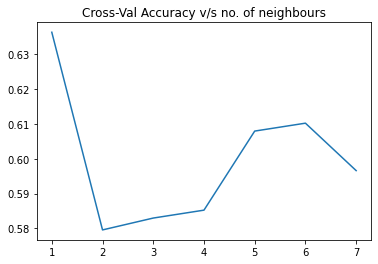

In [37]:
trainX_allSamples = trainDF_User_AllSampleProps.reset_index().drop(columns=['user'])
trainY_allSamples = trainDF_User_AllSampleProps.index

def getCrossValidationAccuracy(n_neighbours):
    knn_allSamples = KNeighborsClassifier(n_neighbours)
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    acc = []
    for train_index, test_index in sss.split(trainX_allSamples, trainY_allSamples):
        knn_allSamples.fit(trainX_allSamples.loc[train_index],trainY_allSamples[train_index])
        acc += [accuracy_score(knn_allSamples.predict(trainX_allSamples.loc[test_index]),trainY_allSamples[test_index])]
    return sum(acc) / len(acc)
allAttemptsAcc = [getCrossValidationAccuracy(i) for i in range(1,8)]
print('Accuracies:',allAttemptsAcc)
sns.lineplot(y=allAttemptsAcc,x=range(1,8)).set_title('Cross-Val Accuracy v/s no. of neighbours')

From the above plot, we can see that we get the highest accuracy, if we use n_neighbours = 1

In [38]:
# knn_allSamples = KNeighborsClassifier(1)
# knn_allSamples.fit(trainX_allSamples,trainY_allSamples)

# testX_allSamples = testDF_User_AllSampleProps.reset_index().drop(columns=['id'])
# textPreds_allSamples = knn_allSamples.predict(testX_allSamples)
# pd.DataFrame({'user':textPreds_allSamples},index=testX_allSamples.index).to_csv('submission.csv',index=False)

## XGB Model

Although this dataset is very small - 8 samples per class and 39 feature columns, let's still try to use XGB for this dataset. Here, as well, let's analyse the cross validation accuracy to be sure that this model can be reliable.

In [39]:
%%time
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=10,
    max_depth=5,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=trainY_allSamples.nunique(),
    nthread=4,
    seed=27)
param_search = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100,200,210,230,250,270,290,310,330],
    'max_depth': range(4,10,1)
}
gsearch2b = GridSearchCV(estimator = xgb1,param_grid = param_search, scoring='accuracy',n_jobs=4,iid=False,cv=StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=0), verbose=1)
gsearch2b.fit(trainX_allSamples, trainY_allSamples)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 18.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 83.5min
[Parallel(n_jobs=4)]: Done 324 out of 324 | elapsed: 135.3min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 48.3 s, sys: 1.24 s, total: 49.5 s
Wall time: 2h 15min 32s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_wei...
                                     num_class=110, num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=27, subsample=0

An exhaustive search is convenient but as you can see the downside from the wall time above. Yes, it takes so much time! But for now, since we have found the optimal parameters for our dataset, let's go ahead and view the best estimator obtained from GridSearchCV

In [40]:
print('Best Estimator:\n',gsearch2b.best_estimator_)

Best Estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=270, n_jobs=4, nthread=4, num_class=110,
              num_parallel_tree=1, objective='multi:softprob', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [41]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
accs = []
for train_index, test_index in sss.split(trainX_allSamples, trainY_allSamples):
    gsearch2b.best_estimator_.fit(trainX_allSamples.loc[train_index],trainY_allSamples[train_index])
    acc = accuracy_score(gsearch2b.best_estimator_.predict(trainX_allSamples.loc[test_index]),trainY_allSamples[test_index])
    print('Accuracy Score:', acc)
    accs += [acc]
print('Average Accuracy:',sum(accs)/len(accs))

Accuracy Score: 0.7159090909090909
Accuracy Score: 0.7329545454545454
Accuracy Score: 0.7556818181818182
Accuracy Score: 0.7159090909090909
Accuracy Score: 0.7443181818181818
Average Accuracy: 0.7329545454545454


Since, the dataset itself is so small, this is the best accuracy I could get

In [42]:
gsearch2b.best_estimator_.fit(trainX_allSamples,trainY_allSamples)

testX_allSamples = testDF_User_AllSampleProps.reset_index().drop(columns=['id'])
textPreds_allSamples = gsearch2b.best_estimator_.predict(testX_allSamples)
pd.DataFrame({'idx':testX_allSamples.index,'user':textPreds_allSamples},index=testX_allSamples.index).to_csv('submission.csv',index=False)

### If you liked my work, please leave an upvote to let me understand the quality of my work. Also, if you have any suggestions or improvements or doubts, I'll be more than happy to discuss them in the comments section below :) 

## Keep Kaggling!